In [1]:
import meld_graph.experiment
import os
import numpy as np
import h5py
import matplotlib_surface_plotting as msp
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import nibabel as nb
from meld_classifier.paths import BASE_PATH
from meld_classifier.meld_cohort import MeldCohort,MeldSubject
def load_prediction(subject,hdf5,dset='prediction'):
    results={}
    with h5py.File(hdf5, "r") as f:
        for hemi in ['lh','rh']:
            results[hemi] = f[subject][hemi][dset][:]
    return results


Setting EXPERIMENT_PATH to /rds/project/kw350/rds-kw350-meld/experiments_graph/co-ripa1
Setting MELD_DATA_PATH to /rds/project/kw350/rds-kw350-meld/meld_data/Data
Setting BASE_PATH to /rds/project/kw350/rds-kw350-meld/meld_data/Data
Setting EXPERIMENT_PATH to /rds/project/kw350/rds-kw350-meld/experiments/co-ripa1/
Setting FS_SUBJECTS_PATH to 


In [2]:
model_path = '/rds/project/kw350/rds-kw350-meld/experiments_graph/kw350/23-01-13_QXFB_kernel_spiral_fold/s_2/'

In [3]:
cohort = MeldCohort(hdf5_file_root='{site_code}_{group}_featurematrix_combat_6.hdf5',
               dataset='MELD_dataset_V6.csv')


In [4]:
folds = np.arange(0,9)

save_dirs = {
    'spiral': [os.path.join(model_path,f'fold_0{fold}', 'results') for fold in folds],
    'old_classifier':'/rds/project/kw350/rds-kw350-meld/experiments/co-ripa1/iteration_21-09-15/ensemble_21-09-15/fold_all/results/predictions_ensemble_iteration.hdf5'
}

In [5]:
n_vert = len(cohort.cortex_label)*2

In [6]:
with h5py.File(os.path.join(save_dirs['spiral'][0], 'predictions.hdf5'), "r") as f:
    subjects = list(f.keys())
len(subjects)


453

In [7]:
import scipy
def cluster_and_area_threshold(cohort, mask, island_count=0, min_area_threshold=0):
    """cluster predictions and threshold based on min_area_threshold

    Args:
        mask: boolean mask of the per-vertex lesion predictions to cluster"""
    n_comp, labels = scipy.sparse.csgraph.connected_components(cohort.adj_mat[mask][:, mask])
    islands = np.zeros(len(mask))
    # only include islands larger than minimum size.
    for island_index in np.arange(n_comp):
        include_vec = labels == island_index
        size = np.sum(include_vec)
        if size >= min_area_threshold:
            island_count += 1
            island_mask = mask.copy()
            island_mask[mask] = include_vec
            islands[island_mask] = island_count
    return islands

In [19]:
#find number of clusters for old classifier and new one
import pandas as pd

#parameters for graph
threshold_value = 0.09
min_area_threshold=100
print(threshold_value)

df=pd.DataFrame()
subjects_dictionary={}
values={}
for si,subj in enumerate(subjects):
    print(subj)
    if si%100==0:
        print(si)
    values['ID']=subj
    s = MeldSubject(subj,cohort=cohort)
    values['group']=s.group
    labels_hemis = {}
    dists={}
    labels = np.zeros(n_vert)
    for hemi in ['lh','rh']:
        dists[hemi], labels_hemis[hemi] = s.load_feature_lesion_data(
                    features=['.on_lh.boundary_zone.mgh'], hemi=hemi, features_to_ignore=[]
                )
        if np.sum(dists[hemi])==0:
            dists[hemi] +=200
    labels = np.hstack([labels_hemis['lh'][cohort.cortex_mask],labels_hemis['rh'][cohort.cortex_mask]])
    borderzones = np.vstack([dists['lh'][cohort.cortex_mask,:],dists['rh'][cohort.cortex_mask,:]]).ravel()<20
    
    #load pred from old classifier
    pred_file_old = os.path.join(save_dirs['old_classifier'])
    result_hemis_old = load_prediction(subj,pred_file_old, dset='prediction')
    result_old = np.hstack([result_hemis_old['lh'],result_hemis_old['rh']])
    values['classifier']='per vertex'
    values['number_clusters']=len(set(result_hemis_old['lh']))+len(set(result_hemis_old['rh']))-2
    #add detection
    if labels.sum()>0:
        values['sensitivity'] = np.logical_and(result_old, labels).any()
        values['sensitivity_plus'] = np.logical_and(result_old, borderzones).any()
    #store specificity for controls (no label)
    else:
        values['specificity'] = ~result_old.any()
    df=pd.concat([df,pd.DataFrame([values])])
    
    #load pred from new classifier
    result_hemis={'lh':np.zeros(int(n_vert/2)),
                'rh':np.zeros(int(n_vert/2)),}
    result_hemis_clustered={}
    for fold in folds:
        save_dir = save_dirs['spiral'][fold]
        #load pred from new classifier and average over fold
        pred_file = os.path.join(save_dir, 'predictions.hdf5')
        result_hemis_fold = load_prediction(subj,pred_file, dset='prediction')
        result_hemis['lh'] += result_hemis_fold['lh']/10
        result_hemis['rh'] += result_hemis_fold['rh']/10
    for h, hemi in enumerate(['lh', 'rh']):
        #threshold new predictions
        mask = np.zeros(len(cohort.cortex_mask), dtype=bool)
        mask[cohort.cortex_mask] = (result_hemis[hemi] >= threshold_value)
        #cluster new predictions
        result_hemis_clustered[hemi] = cluster_and_area_threshold(cohort, mask, min_area_threshold=min_area_threshold)[cohort.cortex_mask]
    result_clustered = np.hstack([result_hemis_clustered['lh'],result_hemis_clustered['rh']])
    values['classifier']='graph'
    values['number_clusters']=len(set(result_hemis_clustered['lh']))+len(set(result_hemis_clustered['rh']))-2
    
    #add detection
    if labels.sum()>0:
        values['sensitivity'] = np.logical_and(result_clustered, labels).any()
        values['sensitivity_plus'] = np.logical_and(result_clustered, borderzones).any()
    #store specificity for controls (no label)
    else:
        values['specificity'] = ~result_clustered.any()
    
    df=pd.concat([df,pd.DataFrame([values])])

0.09
MELD2_H7_3T_FCD_001
0
MELD2_H7_3T_FCD_004
MELD2_H7_3T_FCD_005
MELD2_H7_3T_FCD_009
MELD_H10_3T_C_0005
MELD_H10_3T_C_0006
MELD_H10_3T_C_0009
MELD_H10_3T_C_0011
MELD_H10_3T_C_0012
MELD_H10_3T_C_0013
MELD_H10_3T_C_0014
MELD_H10_3T_C_0015
MELD_H10_3T_C_0017
MELD_H10_3T_C_0018
MELD_H10_3T_C_0019
MELD_H10_3T_C_0021
MELD_H10_3T_C_0022
MELD_H10_3T_C_0025
MELD_H10_3T_C_0028
MELD_H10_3T_C_0029
MELD_H10_3T_C_0031
MELD_H10_3T_FCD_0002
MELD_H10_3T_FCD_0009
MELD_H10_3T_FCD_0013
MELD_H10_3T_FCD_0014
MELD_H10_3T_FCD_0016
MELD_H11_3T_FCD_0002
MELD_H11_3T_FCD_0006
MELD_H11_3T_FCD_0007
MELD_H11_3T_FCD_0009
MELD_H11_3T_FCD_0010
MELD_H11_3T_FCD_0011
MELD_H11_3T_FCD_0015
MELD_H11_3T_FCD_0019
MELD_H11_3T_FCD_0020
MELD_H11_3T_FCD_0025
MELD_H11_3T_FCD_0027
MELD_H11_3T_FCD_0028
MELD_H11_3T_FCD_0030
MELD_H11_3T_FCD_0031
MELD_H11_3T_FCD_0040
MELD_H11_3T_FCD_0041
MELD_H11_3T_FCD_0042
MELD_H11_3T_FCD_0044
MELD_H11_3T_FCD_0045
MELD_H12_3T_C_0002
MELD_H12_3T_C_0004
MELD_H12_3T_C_0005
MELD_H12_3T_C_0007
MELD_H12_3

In [22]:
df

,ID,group,classifier,number_clusters,sensitivity,sensitivity_plus,specificity
0,MELD2_H7_3T_FCD_001,patient,per vertex,3,False,False,NaN
0,MELD2_H7_3T_FCD_001,patient,graph,1,False,True,NaN
0,MELD2_H7_3T_FCD_004,patient,per vertex,1,False,False,NaN
0,MELD2_H7_3T_FCD_004,patient,graph,1,True,True,NaN
0,MELD2_H7_3T_FCD_005,patient,per vertex,0,False,False,NaN
...,...,...,...,...,...,...,...
0,MELD_H9_3T_FCD_0004,patient,graph,3,True,True,True
0,MELD_H9_3T_FCD_0005,patient,per vertex,3,True,True,True
0,MELD_H9_3T_FCD_0005,patient,graph,3,True,True,True
0,MELD_H9_3T_FCD_0010,patient,per vertex,1,False,False,True


In [20]:
for classifier in ['per vertex', 'graph']:
    print(classifier)
    subdf = df[df['classifier']==classifier]
    sensitivity = len(subdf[(subdf['group']=='patient') & (subdf['sensitivity']==True)])/len(subdf[(subdf['group']=='patient')])
    sensitivity_plus = len(subdf[(subdf['group']=='patient') & (subdf['sensitivity_plus']==True)])/len(subdf[(subdf['group']=='patient')])
    specificity = len(subdf[(subdf['group']=='control') & (subdf['specificity']==True)])/len(subdf[(subdf['group']=='control')])
    print(f'sensitivity : {sensitivity}')
    print(f'sensitivity_plus : {sensitivity_plus}')
    print(f'specificity : {specificity}')

per vertex
sensitivity : 0.5923076923076923
sensitivity_plus : 0.6692307692307692
specificity : 0.5440414507772021
graph
sensitivity : 0.6192307692307693
sensitivity_plus : 0.6538461538461539
specificity : 0.7357512953367875


/tmp/ipykernel_61480/1366228235.py:37: MatplotlibDeprecationWarning: Support for passing numbers through unit converters is deprecated since 3.5 and support will be removed two minor releases later; use Axis.convert_units instead.
  axs[i].scatter(x, y, marker='o')


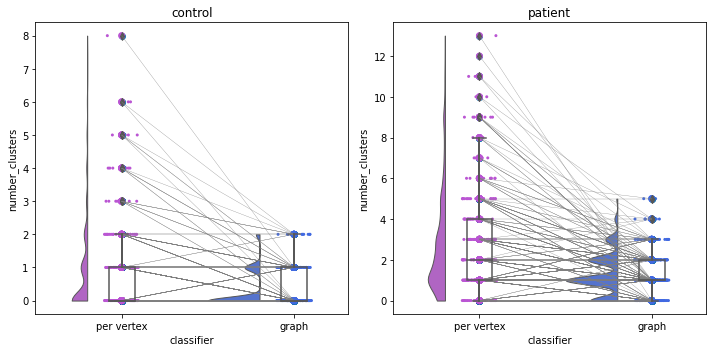

In [21]:
import ptitprince as pt
import matplotlib.gridspec as gridspec

def get_connection(df):
    connects=[]
    for subject in np.unique(df['ID']):
        subdf=df[df['ID']==subject]
        connects.append([subdf[subdf['classifier']=='per vertex'].index[0],
                        subdf[subdf['classifier']=='graph'].index[0]])
    return connects

def connectpoints(x,y,p1,p2,colors):
    x1, x2 = x[p1], x[p2]
    y1, y2 = y[p1], y[p2]
    plt.scatter([x1,x2],[y1,y2], c=colors)
    plt.plot([x1,x2],[y1,y2], 'grey', linewidth=0.3)
    

fig = plt.figure(figsize=(10,5))
gs1 = gridspec.GridSpec(1, 2)
axs = []

ort='v'
pal={'per vertex':'mediumorchid', 'graph':'royalblue'}

for i,group in enumerate(['control','patient']):
    axs.append(fig.add_subplot(gs1[i]))
    subdf=df[df['group']==group]
    subdf.reset_index(drop=True, inplace=True)
    axs[i]=pt.RainCloud(x='classifier', y='number_clusters', palette = pal, data=subdf, bw= .2, cut=0, 
                            scale="area", width_viol=.6, orient=ort, jitter = 0.1, dodge=False)
    axs[i].set_title(group)
    #plot connections
    connects=get_connection(subdf)
    x=subdf['classifier'].to_numpy()
    y=subdf['number_clusters'].to_numpy()
    axs[i].scatter(x, y, marker='o')
    for connect in connects:
        connectpoints(x,y,connect[0],connect[1], colors = [pal['per vertex'],pal['graph']])
    plt.tight_layout()


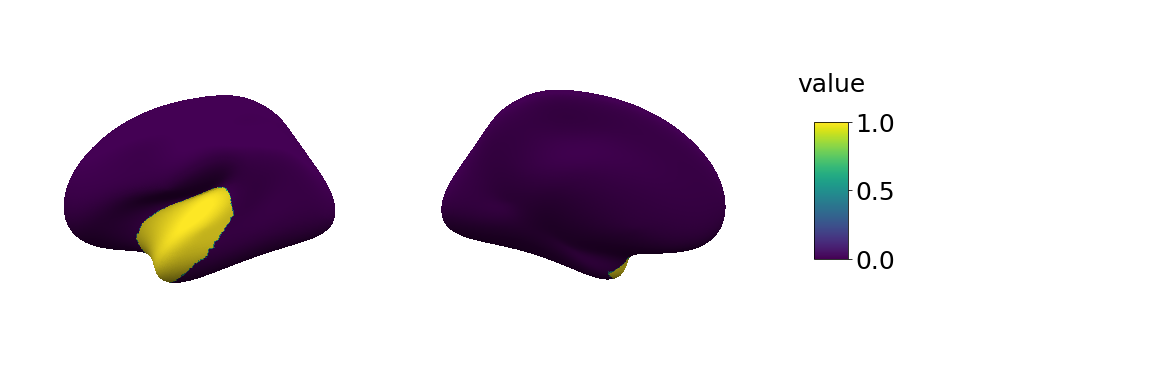

In [62]:
# flat = nb.load(os.path.join(BASE_PATH, "fsaverage_sym", "surf", "lh.full.patch.flat.gii"))
# coords, faces = flat.darrays[0].data, flat.darrays[1].data
coords = cohort.surf["coords"]
faces = cohort.surf["faces"]

overlay=np.zeros(len(cohort.cortex_mask))
# overlay[cohort.cortex_mask]=result_hemis['lh']>0.09
overlay[cohort.cortex_mask]=result_hemis_clustered['lh']
msp.plot_surf(coords,faces, 
                overlay,
                flat_map=False,
                rotate=[90, 270],
             )

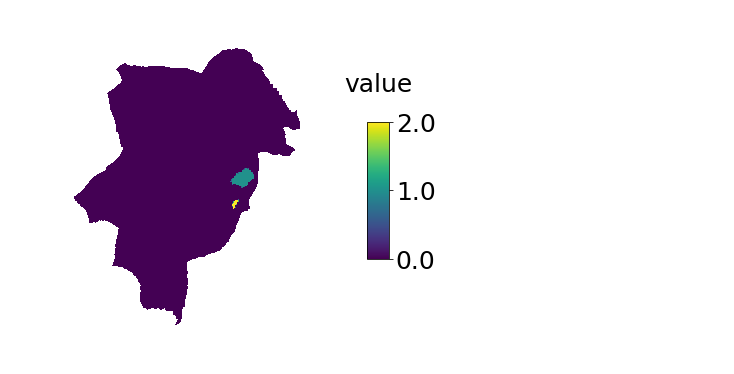

In [54]:
flat = nb.load(os.path.join(BASE_PATH, "fsaverage_sym", "surf", "lh.full.patch.flat.gii"))
coords, faces = flat.darrays[0].data, flat.darrays[1].data

overlay=np.zeros(len(coords))
overlay[cohort.cortex_mask]=result_hemis_old['lh']
msp.plot_surf(coords,faces, 
                overlay,
                flat_map=True,
                rotate=[90, 270],
             )